In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))
add_to_sys_path(os.path.join('..', '..', '..', 'Scaffolding_OOD'))

In [2]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from XGB import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Import modules for the attack
from config import (
    RANDOM_SEED, N_SAMPLES_DATA, BIAS_CORRELATION_STRENGTH, POSITIVE_OUTCOME,
    TEST_SIZE, LIME_PERTURBATION_STD, LIME_PERTURBATION_MULTIPLIER,
    SHAP_N_SAMPLES_OOD, SHAP_N_KMEANS_BACKGROUND, OOD_PRED_THRESHOLD,
    UNPROTECTED_CLASS_VALUE, PROTECTED_CLASS_VALUE
)
from data_handler import generate_base_data, process_data
from bias_injector import add_highly_correlated_biased_feature
from ood_generator import generate_lime_style_ood, generate_shap_style_ood, combine_ood_data_for_detector_training
from ood_detector import OODDetector
from scaffold_model import Adversarial_Lime_Model, Adversarial_Kernel_SHAP_Model, CombinedAdversarialModel
from explainer_helper import get_lime_explanation, get_shap_explanation, print_explanation, plot_explanation_comparison, get_feature_rank_frequencies, plot_feature_rank_distribution

In [4]:
data = pd.read_csv('../../../Dataset/Kaggle-data.csv')
data.head()

,ID,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
0,1,b69acb3bb133974e48229627663f96d4,332,224,8450,8.0,0,16896,8192,0,...,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,NaN
1,2,1cbee4b3725629bd0aa6ac2ff500925f,332,224,258,9.0,0,84480,25600,0,...,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,NaN
2,3,b7027cf0cd31c820928950cbfe7e91ef,332,224,8450,8.0,0,4608,3584,0,...,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,NaN
3,4,156a0bb069f94d1e7c2508318805f2a4,332,224,8450,10.0,0,108544,15872,0,...,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,NaN
4,5,c72bf851fed5542abba904b1f3944cd5,332,224,8226,48.0,0,513024,2048,0,...,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,NaN


In [5]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,ID,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,...,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
0,1,224,8450,8.0,0,16896,8192,0,16947,4096,...,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,NaN
1,2,224,258,9.0,0,84480,25600,0,10973,4096,...,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,NaN
2,3,224,8450,8.0,0,4608,3584,0,6452,4096,...,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,NaN
3,4,224,8450,10.0,0,108544,15872,0,105021,4096,...,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,NaN
4,5,224,8226,48.0,0,513024,2048,0,520922,8192,...,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,NaN


In [6]:
data = data.drop(columns=['ID', 'Unnamed: 57'])
data.head()

,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,224,8450,8.0,0,16896,8192,0,16947,4096,24576,...,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1
1,224,258,9.0,0,84480,25600,0,10973,4096,90112,...,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1
2,224,8450,8.0,0,4608,3584,0,6452,4096,12288,...,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1
3,224,8450,10.0,0,108544,15872,0,105021,4096,114688,...,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1
4,224,8226,48.0,0,513024,2048,0,520922,8192,524288,...,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216352 entries, 0 to 216351
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SizeOfOptionalHeader         216352 non-null  int64  
 1   Characteristics              216352 non-null  int64  
 2   MajorLinkerVersion           216351 non-null  float64
 3   MinorLinkerVersion           216352 non-null  int64  
 4   SizeOfCode                   216352 non-null  int64  
 5   SizeOfInitializedData        216352 non-null  int64  
 6   SizeOfUninitializedData      216352 non-null  int64  
 7   AddressOfEntryPoint          216352 non-null  int64  
 8   BaseOfCode                   216352 non-null  int64  
 9   BaseOfData                   216352 non-null  int64  
 10  ImageBase                    216352 non-null  float64
 11  SectionAlignment             216352 non-null  int64  
 12  FileAlignment                216352 non-null  int64  
 13 

In [8]:
len(data)

216352

In [7]:
protected_feature = 'Subsystem'

In [8]:
data = data.dropna(axis=1)

In [9]:
# biased_data = add_highly_correlated_biased_feature(
#         data,
#         target_column='Label',
#         new_feature_name=protected_feature,
#         correlation_strength=BIAS_CORRELATION_STRENGTH,
#         favor_outcome=POSITIVE_OUTCOME # The protected group (value 1) will be favored for POSITIVE_OUTCOME (value 1)
#     )

biased_data = data.copy()

In [10]:
biased_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216352 entries, 0 to 216351
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SizeOfOptionalHeader         216352 non-null  int64  
 1   Characteristics              216352 non-null  int64  
 2   MinorLinkerVersion           216352 non-null  int64  
 3   SizeOfCode                   216352 non-null  int64  
 4   SizeOfInitializedData        216352 non-null  int64  
 5   SizeOfUninitializedData      216352 non-null  int64  
 6   AddressOfEntryPoint          216352 non-null  int64  
 7   BaseOfCode                   216352 non-null  int64  
 8   BaseOfData                   216352 non-null  int64  
 9   ImageBase                    216352 non-null  float64
 10  SectionAlignment             216352 non-null  int64  
 11  FileAlignment                216352 non-null  int64  
 12  MajorOperatingSystemVersion  216352 non-null  int64  
 13 

Injecting deliberatly some synthetic ood data, if want to go witht the original dataset, just comment out the segment

In [13]:
# # Configuration - OOD samples will be 20% of original data size
# ood_ratio = 0.20
# n_ood = int(len(biased_data) * ood_ratio)

# # Identify integer columns (excluding Label)
# int_cols = [col for col in biased_data.columns 
#             if col != 'Label' and biased_data[col].dtype in ['int64', 'int32']]

# # Handle NaN values while preserving integer types
# for col in biased_data.columns:
#     if col == 'Label':
#         continue
#     if col in int_cols:
#         # For integer columns, fill with rounded median to maintain integers
#         biased_data[col] = biased_data[col].fillna(round(biased_data[col].median())).astype(int)
#     else:
#         # For non-integer columns, use mean
#         biased_data[col] = biased_data[col].fillna(biased_data[col].mean())

# X_clean = biased_data.drop(columns='Label').values
# y_clean = biased_data['Label'].values

# # Train KNN on clean data
# knn = KNeighborsClassifier(n_neighbors=3).fit(X_clean, y_clean)

# # Generate LIME-style OOD (50% of OOD samples)
# lime_samples = X_clean[np.random.choice(len(X_clean), size=n_ood//2, replace=True)]
# X_lime, _ = generate_lime_style_ood(lime_samples, feature_names=biased_data.columns.tolist()[1:])
# lime_labels = knn.predict(X_lime)

# # Generate SHAP-style OOD (remaining 50%)
# shap_samples = X_clean[np.random.choice(len(X_clean), size=n_ood//2, replace=True)]
# X_shap, _ = generate_shap_style_ood(shap_samples, feature_names=biased_data.columns.tolist()[1:])
# shap_labels = knn.predict(X_shap)

# # Directly extend biased_data (no new variables created)
# biased_data = pd.concat([
#     biased_data,
#     pd.DataFrame(X_lime, columns=biased_data.columns.tolist()[1:]).assign(Label=lime_labels),
#     pd.DataFrame(X_shap, columns=biased_data.columns.tolist()[1:]).assign(Label=shap_labels)
# ], ignore_index=True)

# # Convert integer columns back to integers (in case generation created floats)
# for col in int_cols:
#     biased_data[col] = biased_data[col].astype(int)

# print(f"Extended dataset size: {len(biased_data)}")
# print("New label distribution:\n", biased_data['Label'].value_counts())

In [11]:
x_train, x_test, y_train, y_test, feature_names = Data_Handler(
        df=biased_data,
        target_column='legitimate',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling numerical features: ['SizeOfOptionalHeader', 'Characteristics', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MajorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'SizeOfStackReserve', 'SectionsNb', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'ImportsNbDLL', 'ImportsNb', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMeanSize', 'LoadConfigurationSize', 'VersionInformationSize']


In [12]:
print(len(x_train.columns))
x_train.head()

29


,SizeOfOptionalHeader,Characteristics,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,ImageBase,SectionAlignment,FileAlignment,...,SectionsMeanRawsize,SectionsMinRawsize,ImportsNbDLL,ImportsNb,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,LoadConfigurationSize,VersionInformationSize
23719,-0.305427,0.486617,-0.012571,-0.019644,-0.018098,-0.013143,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.019011,-0.059338,0.026381,0.428386,-0.085713,-0.155414,-0.191340,-0.006211,-0.021652,-0.976969
76197,-0.305427,3.645773,-0.002361,-0.000923,-0.018098,0.014050,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.006661,-0.062737,0.009141,1.898300,-0.089408,2.955649,1.994856,-0.006194,-0.021655,-0.976969
26038,-0.305427,0.486617,-0.006133,-0.018636,-0.018098,-0.018213,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.015771,-0.059338,0.029829,1.109036,-0.019210,-0.140051,-0.321922,-0.006127,-0.021652,-0.976969
201594,-0.305427,-0.560471,-0.018263,-0.004957,-0.017868,-0.026694,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.019720,-0.062737,-0.000053,0.421146,-0.089408,-0.001782,-0.254559,-0.005931,-0.021655,-0.976969
211321,-0.305427,-0.560471,-0.014288,-0.007098,-0.018098,-0.021836,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.009384,-0.030447,-0.001203,0.008411,-0.089408,0.005900,2.325660,-0.005507,-0.021654,0.763062


In [13]:
feature_names

['SizeOfOptionalHeader',
 'Characteristics',
 'SizeOfCode',
 'SizeOfInitializedData',
 'SizeOfUninitializedData',
 'AddressOfEntryPoint',
 'BaseOfCode',
 'ImageBase',
 'SectionAlignment',
 'FileAlignment',
 'MajorOperatingSystemVersion',
 'MajorImageVersion',
 'MajorSubsystemVersion',
 'MinorSubsystemVersion',
 'SizeOfHeaders',
 'CheckSum',
 'Subsystem',
 'SizeOfStackReserve',
 'SectionsNb',
 'SectionsMeanRawsize',
 'SectionsMinRawsize',
 'ImportsNbDLL',
 'ImportsNb',
 'ExportNb',
 'ResourcesNb',
 'ResourcesMeanEntropy',
 'ResourcesMeanSize',
 'LoadConfigurationSize',
 'VersionInformationSize']

Accuracy: 0.9713739869965796
Precision: 0.9713332322045082
Recall: 0.9713739869965796
F-1: 0.9713415686542073


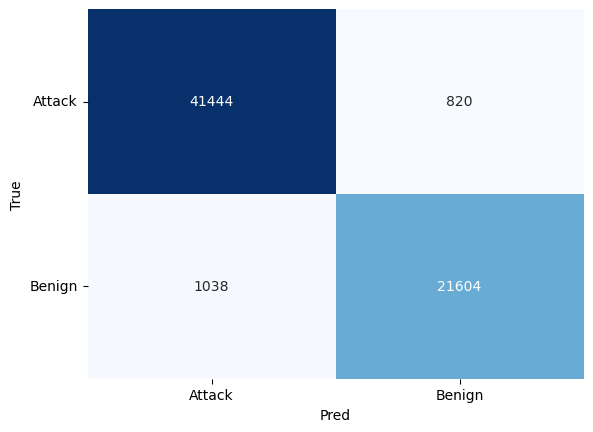

In [14]:
# With the protected feature
f_obscure = base_model_call(x_train, y_train, protected_feature, True)
y_pred_f_obscure = f_obscure.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_f_obscure)

Accuracy: 0.9695713801497551
Precision: 0.9695274227112725
Recall: 0.9695713801497551
F-1: 0.969538361117884


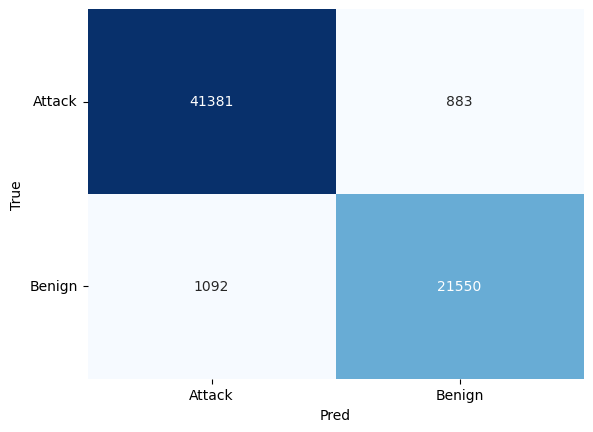

In [15]:
# Without the protected feature
psi_display = base_model_call(x_train, y_train, protected_feature, False)
y_pred_psi_display = psi_display.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_psi_display)

In [19]:
# adv_lime_model = Adversarial_Lime_Model(f_obscure, psi_display, perturbation_std=LIME_PERTURBATION_STD)
# adv_lime_model.train(x_train, feature_names, perturbation_multiplier=LIME_PERTURBATION_MULTIPLIER)
adv_lime_model = CombinedAdversarialModel(f_obscure, psi_display)
adv_lime_model.train(x_train, feature_names)
print(f"Adversarial LIME Model fidelity on test set: {adv_lime_model.fidelity(x_test):.4f}")
print(f"Adversarial LIME Model accuracy on test set: {adv_lime_model.score(x_test, y_test):.4f}")

--- OOD Generator: Generating LIME-style OOD data ---


Generated 151445 LIME-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 1.0000
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     30289
           1       1.00      1.00      1.00     30289

    accuracy                           1.00     60578
   macro avg       1.00      1.00      1.00     60578
weighted avg       1.00      1.00      1.00     60578

--- OOD Generator: Generating SHAP-style OOD data ---

Generated 151445 SHAP-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 0.9988
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     30289
           1       1.00      1.00      1.00     30289

    accu

In [20]:
adv_lime_model.print_ood_stats(x_test)


=== Combined OOD Detection Report ===
Samples processed: 64906
LIME OOD detected: 0 (0.00%)
SHAP OOD detected: 118 (0.18%)
Combined OOD detected: 118 (0.18%)


In [21]:
# adv_shap_model = Adversarial_Kernel_SHAP_Model(f_obscure, psi_display)
# adv_shap_model.train(x_train, feature_names, n_samples=SHAP_N_SAMPLES_OOD, n_kmeans=SHAP_N_KMEANS_BACKGROUND)
adv_shap_model = CombinedAdversarialModel(f_obscure, psi_display)
adv_shap_model.train(x_train, feature_names)
print(f"Adversarial SHAP Model fidelity on test set: {adv_shap_model.fidelity(x_test):.4f}")
print(f"Adversarial SHAP Model accuracy on test set: {adv_shap_model.score(x_test, y_test):.4f}")

--- OOD Generator: Generating LIME-style OOD data ---
Generated 151445 LIME-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 1.0000
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     30289
           1       1.00      1.00      1.00     30289

    accuracy                           1.00     60578
   macro avg       1.00      1.00      1.00     60578
weighted avg       1.00      1.00      1.00     60578

--- OOD Generator: Generating SHAP-style OOD data ---

Generated 151445 SHAP-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 0.9988
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     30289
         

In [22]:
adv_shap_model.print_ood_stats(x_test)


=== Combined OOD Detection Report ===
Samples processed: 64906
LIME OOD detected: 0 (0.00%)
SHAP OOD detected: 118 (0.18%)
Combined OOD detected: 118 (0.18%)


In [23]:
# Select an instance from the test set to explain
instance_to_explain_idx = 1 # Choose the first test instance
instance_to_explain = np.array(x_test.iloc[[instance_to_explain_idx]])
original_prediction = f_obscure.predict(instance_to_explain)
print(f"\nExplaining instance {instance_to_explain_idx} (true label: {y_test.iloc[instance_to_explain_idx]}, f_obscure predicts: {original_prediction})")
x_test.iloc[[instance_to_explain_idx]]



Explaining instance 1 (true label: 0, f_obscure predicts: [0])


,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,ImageBase,SectionAlignment,...,SectionsNb,SectionsMeanRawsize,SectionsMinRawsize,ImportsNb,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,LoadConfigurationSize,VersionInformationSize
121876,-0.305154,-0.561048,0.010194,-0.014549,-0.00781,-0.017655,-0.016539,-0.008912,-0.005751,-0.006757,...,0.038719,-0.009925,-0.030535,-0.197352,-0.091228,-0.114256,-0.064898,-0.007436,-0.020053,0.886403


In [24]:
# LIME for f_obscure
lime_exp_f_obscure = get_lime_explanation(
        f_obscure,
        instance_to_explain,
        feature_names,
        x_train, # LIME explainer needs training data for background distribution
        class_names=['Benign', 'Malicious']
    )
# print_explanation(lime_exp_f_obscure, feature_names, "LIME Explanation (Original Biased Model)", predicted_class=original_prediction)

In [25]:
shap_background_f_obscure = shap.sample(x_train, 100)
shap_exp_f_obscure = get_shap_explanation(
        f_obscure,
        instance_to_explain.reshape(1, -1), # SHAP expects 2D array
        feature_names,
        shap_background_f_obscure,
        class_names=['Benign', 'Malicious'],
        explainer_type='kernel'
    )
# print_explanation(shap_exp_f_obscure, feature_names, "SHAP Kernel Explanation (Original Biased Model)", predicted_class=original_prediction)

In [26]:
# LIME for Adversarial LIME Model
lime_exp_adv_lime = get_lime_explanation(
        adv_lime_model,
        instance_to_explain,
        feature_names,
        x_train, # LIME explainer needs training data for background distribution
        class_names=['Benign', 'Malicious']
    )
# print_explanation(lime_exp_adv_lime, feature_names, "LIME Explanation (Adversarial LIME Model)", predicted_class=original_prediction)

In [27]:
# SHAP (KernelExplainer) for Adversarial SHAP Model
shap_background_adv_shap = shap.sample(x_train, 100) # Use a sample of training data for background
shap_exp_adv_shap = get_shap_explanation(
        adv_shap_model,
        instance_to_explain.reshape(1, -1), # SHAP expects 2D array
        feature_names,
        shap_background_adv_shap,
        class_names=['Benign', 'Malicious'],
        explainer_type='kernel'
    )
# print_explanation(shap_exp_adv_shap, feature_names, "SHAP Kernel Explanation (Adversarial SHAP Model)", predicted_class=original_prediction)

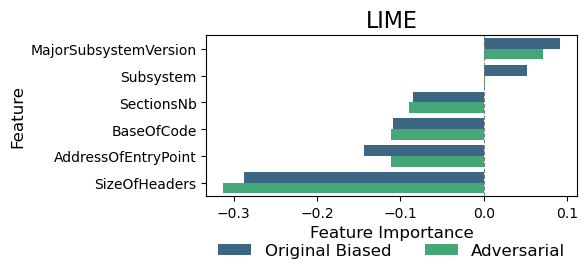

In [28]:
# Plot LIME explanations comparison
plot_explanation_comparison(
        lime_exp_f_obscure,
        lime_exp_adv_lime,
        feature_names,
        protected_feature,
        "LIME",
        predicted_class=original_prediction
    )

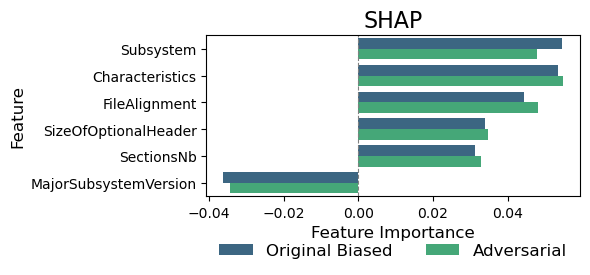

In [29]:
# Plot SHAP explanations comparison
plot_explanation_comparison(
        shap_exp_f_obscure,
        shap_exp_adv_shap,
        feature_names,
        protected_feature,
        "SHAP",
        predicted_class=original_prediction
    )

In [30]:
X_test, X_train = np.array(x_test), np.array(x_train)

In [31]:
def get_categorical_feature_indices(all_feature_names: list, numerical_feature_names: list) -> list:
    """
    Identifies categorical feature names and their indices by excluding numerical features
    from the complete list of feature names.

    Args:
        all_feature_names (list): A list containing all feature names in their original order.
        numerical_feature_names (list): A list containing the names of numerical features.

    Returns:
        list: A sorted list of integer indices corresponding to the categorical features.
    """
    # Convert numerical_feature_names to a set for efficient lookup
    numerical_features_set = set(numerical_feature_names)

    categorical_feature_names = []
    categorical_feature_indices = []

    # Iterate through all feature names to identify categorical ones
    for i, feature_name in enumerate(all_feature_names):
        if feature_name not in numerical_features_set:
            categorical_feature_names.append(feature_name)
            categorical_feature_indices.append(i)

    # Sort the indices to ensure consistent order
    categorical_feature_indices.sort()

    return categorical_feature_indices

In [32]:
# Use a sample of the test data for frequency analysis
num_instances_for_frequency_analysis = min(1000, X_test.shape[0]) # Increased sample size for better statistics
X_freq_sample = X_test[:num_instances_for_frequency_analysis]
# Get predictions for each model on the sample for correct 'predicted_class'
y_pred_freq_sample_f_obscure = f_obscure.predict(X_freq_sample)
y_pred_freq_sample_adv_lime = adv_lime_model.predict(X_freq_sample)
y_pred_freq_sample_adv_shap = adv_shap_model.predict(X_freq_sample)

# SHAP background data for frequency analysis
shap_background_freq = shap.sample(X_train, 100)

top_n_for_rank_plot = 5

lime_categorical_features_indices = get_categorical_feature_indices(x_train.columns, ['SizeOfOptionalHeader', 'Characteristics', 'MajorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MajorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'SizeOfStackReserve', 'SectionsNb', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'ImportsNb', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMeanSize', 'LoadConfigurationSize', 'VersionInformationSize'])

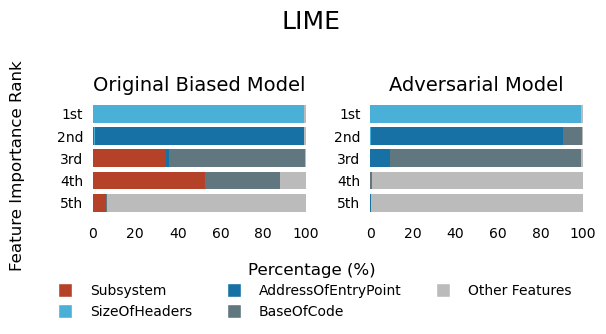

In [34]:
# --- LIME Rank Frequency Analysis ---
lime_rank_freq_data = {}
lime_rank_freq_data['Original Biased Model'] = get_feature_rank_frequencies(
        f_obscure, 'lime', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
        X_train, None, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious'],
        categorical_feature_indices=lime_categorical_features_indices # <--- PASS ALL CATEGORICAL INDICES
    )
lime_rank_freq_data['Adversarial Model'] = get_feature_rank_frequencies(
        adv_lime_model, 'lime', X_freq_sample, feature_names, y_pred_freq_sample_adv_lime,
        X_train, None, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious'],
        categorical_feature_indices=lime_categorical_features_indices # <--- PASS ALL CATEGORICAL INDICES
    )

plot_feature_rank_distribution(
        lime_rank_freq_data, 'LIME', protected_feature,
        "LIME", top_n=top_n_for_rank_plot
    )

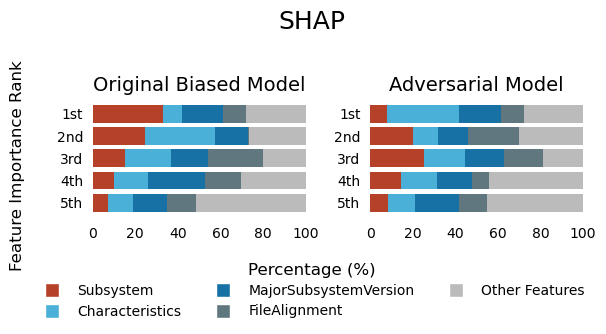

In [35]:
# --- SHAP Rank Frequency Analysis ---
shap_rank_freq_data = {}
shap_rank_freq_data['Original Biased Model'] = get_feature_rank_frequencies(
        f_obscure, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
        None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
    )
shap_rank_freq_data['Adversarial Model'] = get_feature_rank_frequencies(
        adv_shap_model, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_adv_shap,
        None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
    )
# REMOVED: The 'Innocuous (psi)' model is no longer included in the plot data.
# shap_rank_freq_data['Innocuous (psi)'] = get_feature_rank_frequencies(
#         psi_display, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
#         None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
#     )

plot_feature_rank_distribution(
        shap_rank_freq_data, 'SHAP', protected_feature, # Ensure 'protected_feature' is defined in your notebook
        "SHAP", top_n=top_n_for_rank_plot
    )